In [33]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

In [34]:
# Definição da classe do modelo Custom ResNet50
class CustomResNet50(nn.Module):
    def __init__(self, num_classes=None):
        super(CustomResNet50, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        for param in list(self.resnet50.parameters())[-4:]:
            param.requires_grad = True
        self.num_features = self.resnet50.fc.in_features
        
        self.num_classes = num_classes
        if num_classes is not None:
            self.set_num_classes(num_classes)
    
    def set_num_classes(self, num_classes):
        """Define o número de classes dinamicamente e substitui a camada fc"""
        self.num_classes = num_classes
        self.resnet50.fc = nn.Sequential(
            nn.Linear(self.num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        return self.resnet50(x)

c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Danil\AppData\Local\Temp\ipykernel_18400\134741224.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpick


Iniciando validação...

Executando a fase de validacao...

Validação concluída. Tempo: 18.36s
Erro: 0.8510, Acurácia: 70.25%

Métricas de Validação:
Acurácia: 0.7025
Precisão: 0.7084
Recall: 0.7025
F1-Score: 0.7029

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.55      0.66      0.60       322
           1       0.73      0.69      0.71       288
           2       0.61      0.52      0.56       248
           3       0.60      0.48      0.54       318
           4       0.97      0.87      0.91       505
           5       0.84      0.91      0.87       513
           6       0.54      0.61      0.57       310
           7       0.60      0.63      0.62       404

    accuracy                           0.70      2908
   macro avg       0.68      0.67      0.67      2908
weighted avg       0.71      0.70      0.70      2908



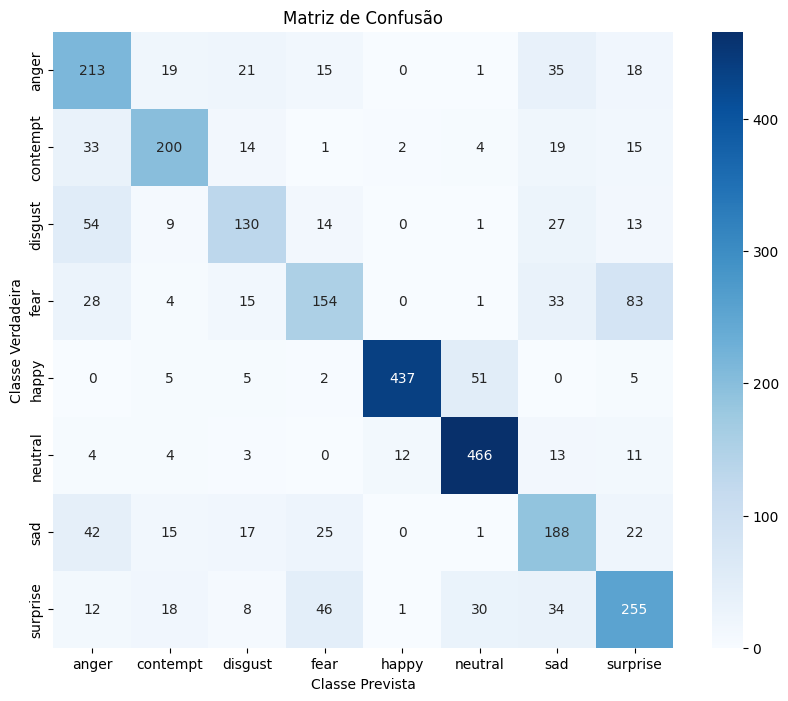

In [35]:


import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import time

class ModelEvaluator:
    def __init__(self, model, data_loader_validacao, num_imagens_validacao, device, nameModel='model.pt'):
        """
        Inicializa a classe ModelEvaluator.

        Parâmetros:
        - model: O modelo a ser avaliado.
        - data_loader_validacao: DataLoader para o conjunto de validação.
        - num_imagens_validacao: Número total de imagens de validação.
        - device: Dispositivo onde o modelo será avaliado (CPU ou GPU).
        - nameModel: Nome do arquivo para carregar o modelo.
        """
        self.model = model
        self.data_loader_validacao = data_loader_validacao
        self.num_imagens_validacao = num_imagens_validacao
        self.device = device
        self.nameModel = nameModel
        self.model.load_state_dict(torch.load(self.nameModel, map_location=self.device))
        self.model.to(self.device)
        self.funcao_erro = nn.CrossEntropyLoss()

    def validar(self):
        inicio = time.time()
        print("\nIniciando validação...")

        erro_validacao, acuracia_validacao, predicoes_validacao, labels_validacao = self.executar_fase('validacao', return_predictions=True)

        fim = time.time()
        print(f"\nValidação concluída. Tempo: {fim - inicio:.2f}s")
        print(f"Erro: {erro_validacao:.4f}, Acurácia: {acuracia_validacao * 100:.2f}%")

        # Calcular métricas finais
        self.calcular_metricas(predicoes_validacao, labels_validacao)

    def executar_fase(self, fase, return_predictions=False):
        """
        Executa a fase de validação, coletando previsões e rótulos reais para avaliação de métricas.
        """
        self.model.eval()
        data_loader = self.data_loader_validacao
        num_imagens = self.num_imagens_validacao

        erro_total = 0.0
        acuracia_total = 0.0
        todas_predicoes = []
        todas_labels = []

        with torch.no_grad():
            print(f"\nExecutando a fase de {fase}...")
            for entradas, labels in data_loader:
                entradas, labels = entradas.to(self.device), labels.to(self.device)

                saidas = self.model(entradas)
                erro = self.funcao_erro(saidas, labels)
                erro_total += erro.item() * entradas.size(0)

                _, predicoes = torch.max(saidas, 1)
                acuracia_total += (predicoes == labels).sum().item()

                if return_predictions:
                    todas_predicoes.extend(predicoes.cpu().numpy())
                    todas_labels.extend(labels.cpu().numpy())

        erro_medio = erro_total / num_imagens
        acuracia_media = acuracia_total / num_imagens

        if return_predictions:
            return erro_medio, acuracia_media, todas_predicoes, todas_labels
        else:
            return erro_medio, acuracia_media

    def calcular_metricas(self, predicoes, labels):
        """
        Calcula e exibe as métricas principais de avaliação do modelo.
        """
        acuracia = accuracy_score(labels, predicoes)
        precisao = precision_score(labels, predicoes, average='weighted', zero_division=0)
        recall = recall_score(labels, predicoes, average='weighted', zero_division=0)
        f1 = f1_score(labels, predicoes, average='weighted', zero_division=0)

        print("\nMétricas de Validação:")
        print(f"Acurácia: {acuracia:.4f}")
        print(f"Precisão: {precisao:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")

        print("\nRelatório de Classificação:")
        print(classification_report(labels, predicoes, zero_division=0))

        self.plotar_matriz_confusao(labels, predicoes)

    def plotar_matriz_confusao(self, labels, predicoes):
        """
        Plota a matriz de confusão para avaliação visual do desempenho do modelo.
        """
        matriz_confusao = confusion_matrix(labels, predicoes)
        plt.figure(figsize=(10, 8))
        sns.heatmap(matriz_confusao, annot=True, fmt="d", cmap="Blues", xticklabels=self.data_loader_validacao.dataset.classes, yticklabels=self.data_loader_validacao.dataset.classes)
        plt.ylabel('Classe Verdadeira')
        plt.xlabel('Classe Prevista')
        plt.title('Matriz de Confusão')
        plt.show()




import torch
from torchvision import datasets, transforms

# Configuração do dispositivo e transformações
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transformacoes_validacao = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor()
])

# Caminho do conjunto de validação e modelo salvo
dataset_path = r'../data/affectnet/processed/imagens_processed'
val_dataset = datasets.ImageFolder(os.path.join(dataset_path, 'validacao'), transform=transformacoes_validacao)
data_loader_validacao = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Caminho do modelo salvo
model_path = './affectnet.pt'

# Instancia e executa a avaliação usando a nova classe ModelEvaluator
evaluator = ModelEvaluator(CustomResNet50(num_classes=8), data_loader_validacao, len(val_dataset), device, nameModel=model_path)
evaluator.validar()

